# TriageAssist: auditing the dataset

In [3]:
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

## Load Dataset

In [20]:
# load data
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

### 1 = male, 0 = female
print(df.isnull().sum())
print(df.head())

df['Sex'] = df.Sex.map({'F': 'female', 'M': 'male'})

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4    

In [8]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,male,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,female,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,male,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,female,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,male,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Dataset Imbalance

In [10]:
categorical_features = ["Sex"]

for col_name in categorical_features:
    df[col_name] = df[col_name].astype("category")

Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]))

In [11]:
# gender
A.value_counts(normalize=True)

Sex
male      0.78976
female    0.21024
Name: proportion, dtype: float64

In [12]:
# target
Y.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

### Add synthetic noise that is related to the outcome and sex

In [21]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

df['Sex'] = df.Sex.map({'F': 2, 'M': 1})
Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]))
X.loc[:, "Fatigue"] = np.random.normal(loc=2 * Y, scale=A)

In [22]:
# gender
A.value_counts(normalize=True)

Sex
1    0.78976
2    0.21024
Name: proportion, dtype: float64

In [23]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Fatigue
0,40,140,289,0,172,0.0,False,True,False,False,False,True,False,True,False,False,False,True,0.405121
1,49,160,180,0,156,1.0,False,False,True,False,False,True,False,True,False,False,True,False,2.861835
2,37,130,283,0,98,0.0,False,True,False,False,False,False,True,True,False,False,False,True,1.242878
3,48,138,214,0,108,1.5,True,False,False,False,False,True,False,False,True,False,True,False,0.488885
4,54,150,195,0,122,0.0,False,False,True,False,False,True,False,True,False,False,False,True,0.393633


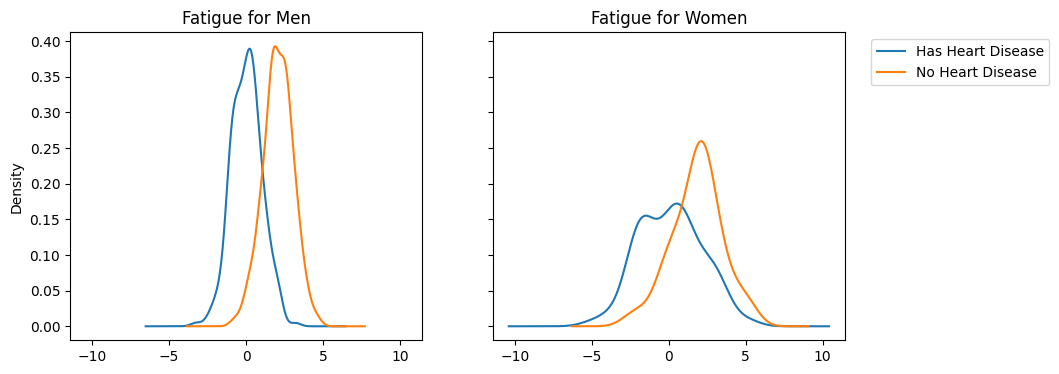

In [25]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Fatigue"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Has Heart Disease", ax=ax_1, title="Fatigue for Men"
)
X["Fatigue"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="No Heart Disease", ax=ax_1
)
X["Fatigue"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Has Heart Disease",
    ax=ax_2,
    legend=True,
    title="Fatigue for Women",
)
X["Fatigue"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="No Heart Disease", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

### Training an initial model

In [26]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [27]:
A_str = A.map({1: "male", 2: "female"})
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [29]:
import lightgbm as lgb

lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 330, number of negative: 330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234))])

In [30]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

In [31]:
roc_auc_score(y_test, Y_pred_proba)

0.9580992509363296

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

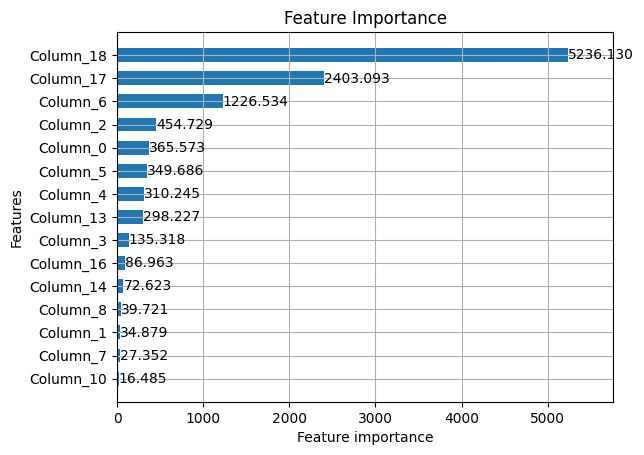

In [32]:
lgb.plot_importance(
    estimator.named_steps["classifier"],
    height=0.6,
    title="Feature Importance",
    importance_type="gain",
    max_num_features=15,
)

## Classification

In [28]:
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

columns = [
    "Sex",
    "ChestPainType",
    "RestingECG",
     "ExerciseAngina",
    "ST_Slope"
]
df = pd.get_dummies(df, prefix = columns  , columns = columns , dtype = float)

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [33]:
target = df["HeartDisease"]
features = df.drop("HeartDisease", axis = 1)

In [34]:
print(len(features.columns), "features are used for training.")

20 features are used for training.


In [35]:
X_train , X_val, y_train, y_val = train_test_split(features, target, train_size = 0.8)

In [36]:
# normalization
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_val = (X_val - np.mean(X_val))/np.std(X_val)

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn import tree

### Decision Tree

In [58]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

Training accuracy: 100.00% | Validation accuracy: 76.09%
Training accuracy: 94.69% | Validation accuracy: 76.09%
Training accuracy: 88.28% | Validation accuracy: 84.78%
Training accuracy: 87.06% | Validation accuracy: 87.50%
Training accuracy: 85.42% | Validation accuracy: 85.33%
Training accuracy: 83.51% | Validation accuracy: 84.24%
Training accuracy: 83.38% | Validation accuracy: 84.24%
Training accuracy: 81.06% | Validation accuracy: 82.61%


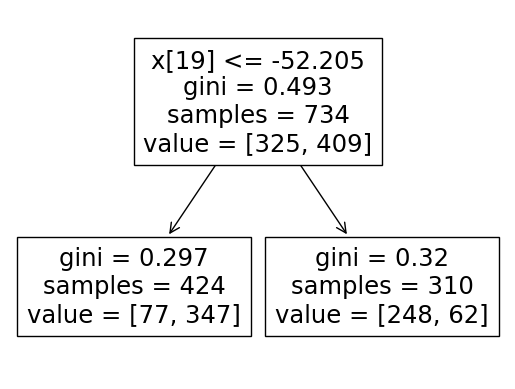

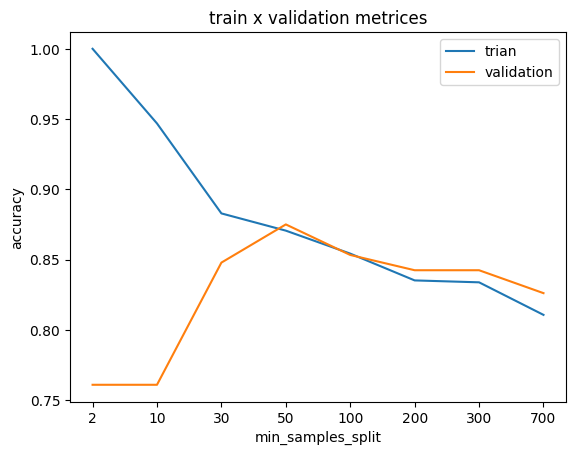

In [59]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples).fit(X_train, y_train)
    tree.plot_tree(model)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_val)*100))
    accuracy_list_train.append(accuracy_score(train_pred, y_train))
    accuracy_list_val.append(accuracy_score(val_pred, y_val))
plt.show()  
    
plt.title("train x validation metrices")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(["trian", "validation"])

Training accuracy: 81.06% | Validation accuracy: 82.61%
Training accuracy: 83.38% | Validation accuracy: 84.24%
Training accuracy: 85.42% | Validation accuracy: 83.70%
Training accuracy: 87.60% | Validation accuracy: 85.87%
Training accuracy: 95.78% | Validation accuracy: 76.63%
Training accuracy: 100.00% | Validation accuracy: 79.89%
Training accuracy: 100.00% | Validation accuracy: 79.89%
Training accuracy: 100.00% | Validation accuracy: 79.89%
Training accuracy: 100.00% | Validation accuracy: 79.89%


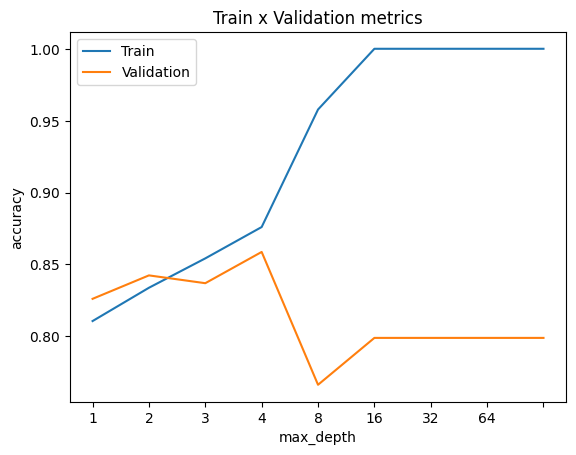

In [78]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 234).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))
    

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 86.65% | Validation accuracy: 87.50%


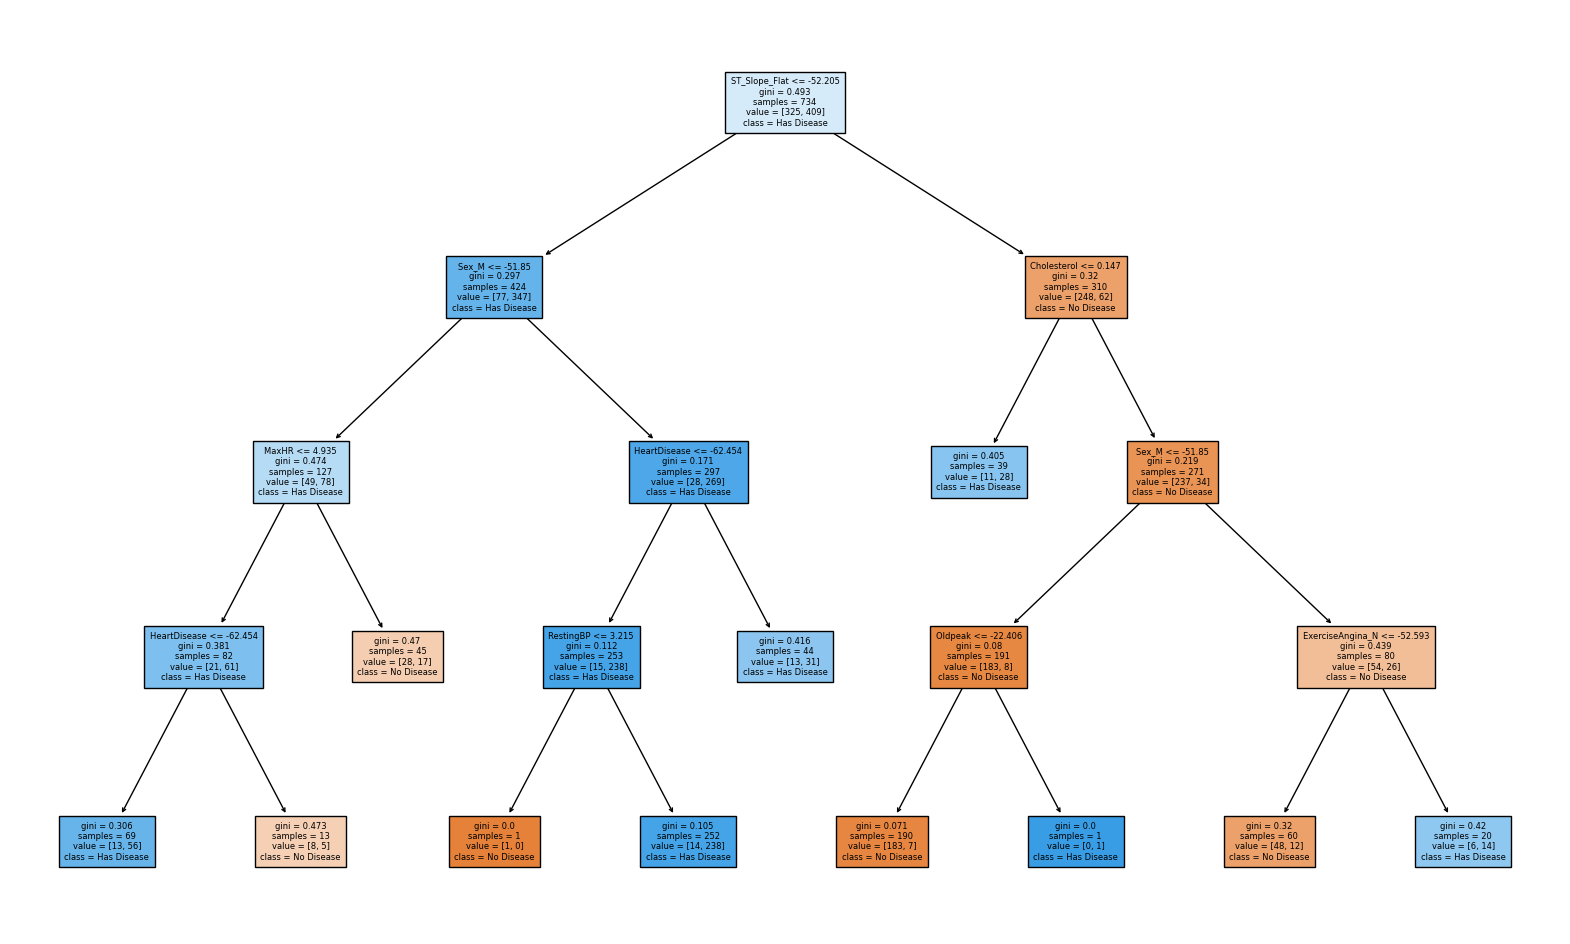

In [80]:
feature_names = list(df.columns)
fig, ax = plt.subplots(1,1,figsize=(20,12))
model = DecisionTreeClassifier(min_samples_split = 50, max_depth=4).fit(X_train, y_train)
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_val)*100))
    

tree.plot_tree(model, feature_names = feature_names, ax=ax, fontsize=6, class_names=['No Disease', 'Has Disease'], filled=True)
plt.show()

### Random Forest

Training accuracy: 100.00% | Validation accuracy: 69.02%
Training accuracy: 94.28% | Validation accuracy: 75.54%
Training accuracy: 88.83% | Validation accuracy: 76.63%
Training accuracy: 87.74% | Validation accuracy: 82.61%
Training accuracy: 86.24% | Validation accuracy: 82.61%
Training accuracy: 85.69% | Validation accuracy: 81.52%
Training accuracy: 83.92% | Validation accuracy: 76.09%
Training accuracy: 55.72% | Validation accuracy: 53.80%


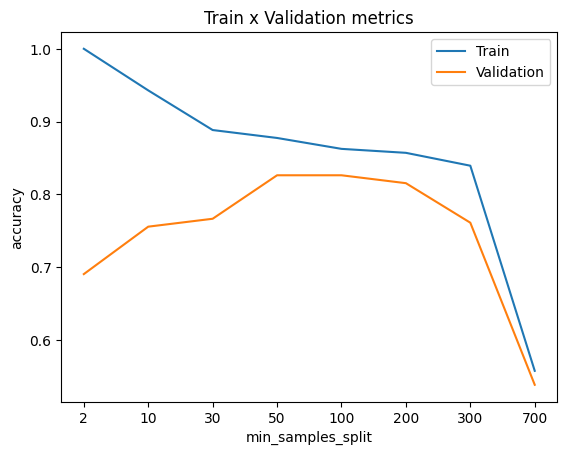

In [81]:
n_estimators_list = [10,50,100,500]
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 234).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 83.92% | Validation accuracy: 84.24%
Training accuracy: 84.60% | Validation accuracy: 77.17%
Training accuracy: 86.78% | Validation accuracy: 77.72%
Training accuracy: 88.69% | Validation accuracy: 77.17%
Training accuracy: 96.32% | Validation accuracy: 76.63%
Training accuracy: 100.00% | Validation accuracy: 75.54%
Training accuracy: 100.00% | Validation accuracy: 76.63%
Training accuracy: 100.00% | Validation accuracy: 76.63%
Training accuracy: 100.00% | Validation accuracy: 76.63%


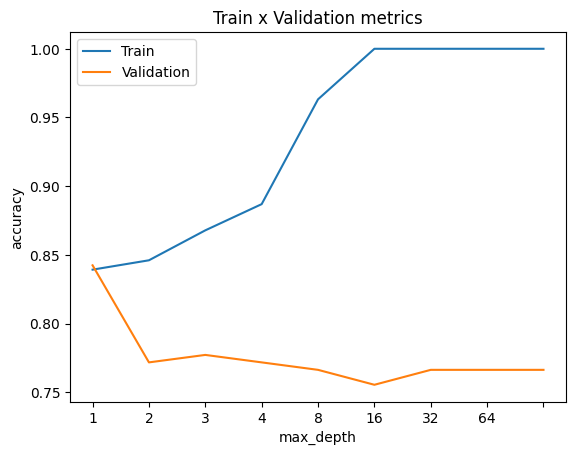

In [83]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 55).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Training accuracy: 99.18% | Validation accuracy: 72.28%
Training accuracy: 99.86% | Validation accuracy: 72.83%
Training accuracy: 100.00% | Validation accuracy: 75.54%
Training accuracy: 100.00% | Validation accuracy: 75.00%


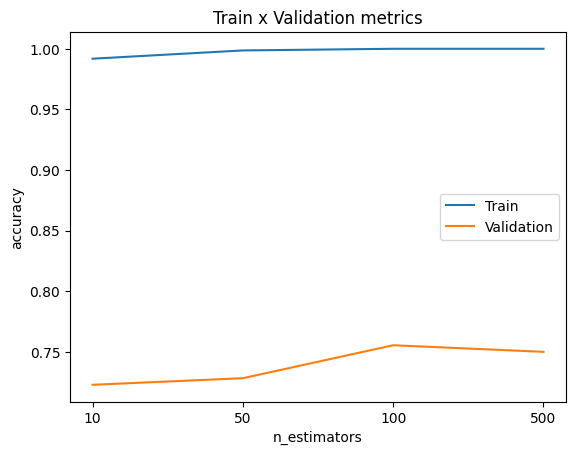

In [86]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 21).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_train*100, accuracy_val*100))

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

In [126]:
random_forest_model = RandomForestClassifier(max_depth = 8, 
                                            min_samples_split = 50,
                                            n_estimators = 10,
                                            random_state = 21).fit(X_train, y_train)

train_pred = random_forest_model.predict(X_train)
val_pred = random_forest_model.predict(X_val)
print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_val)*100))
    

Training accuracy: 87.33% | Validation accuracy: 85.87%


Training accuracy: 87.33% | Validation accuracy: 85.87%


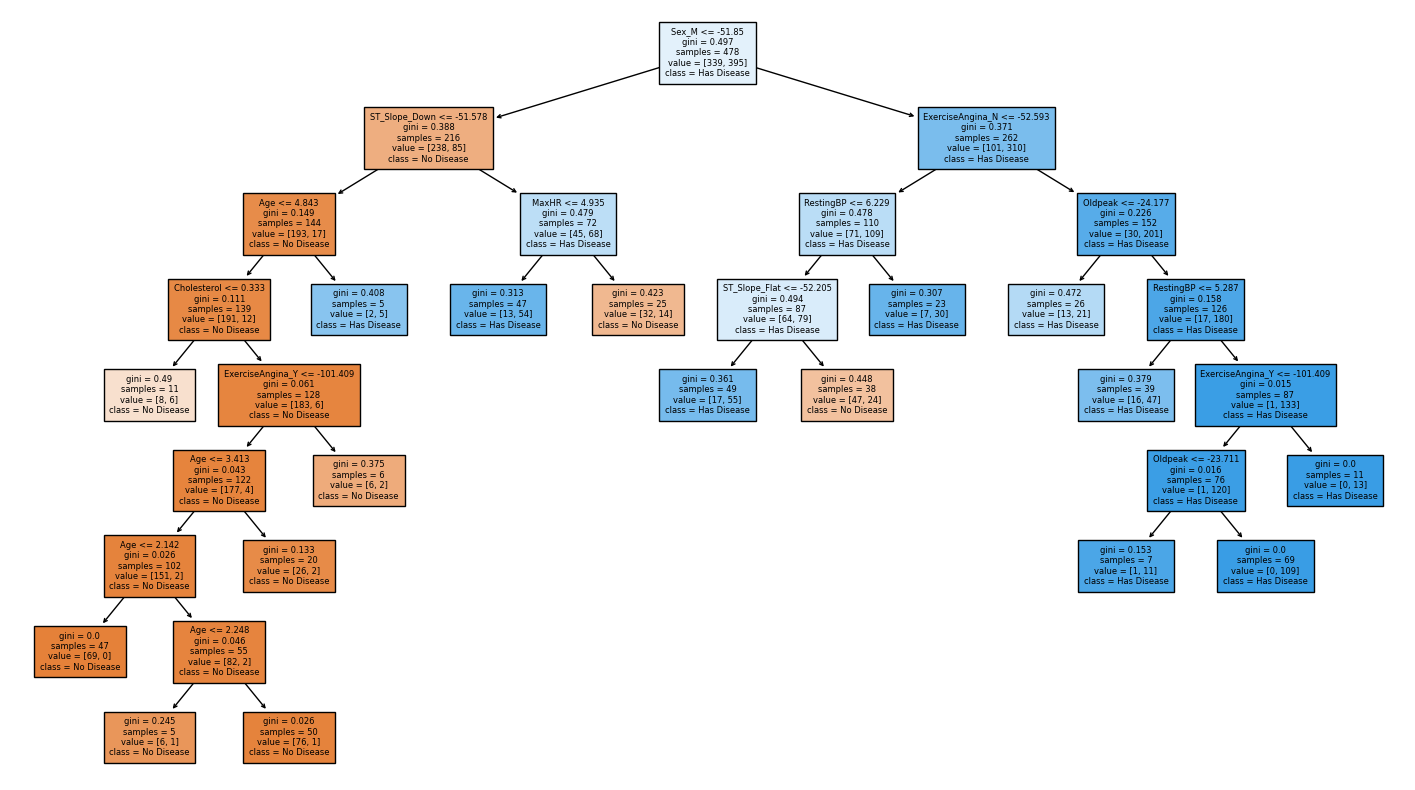

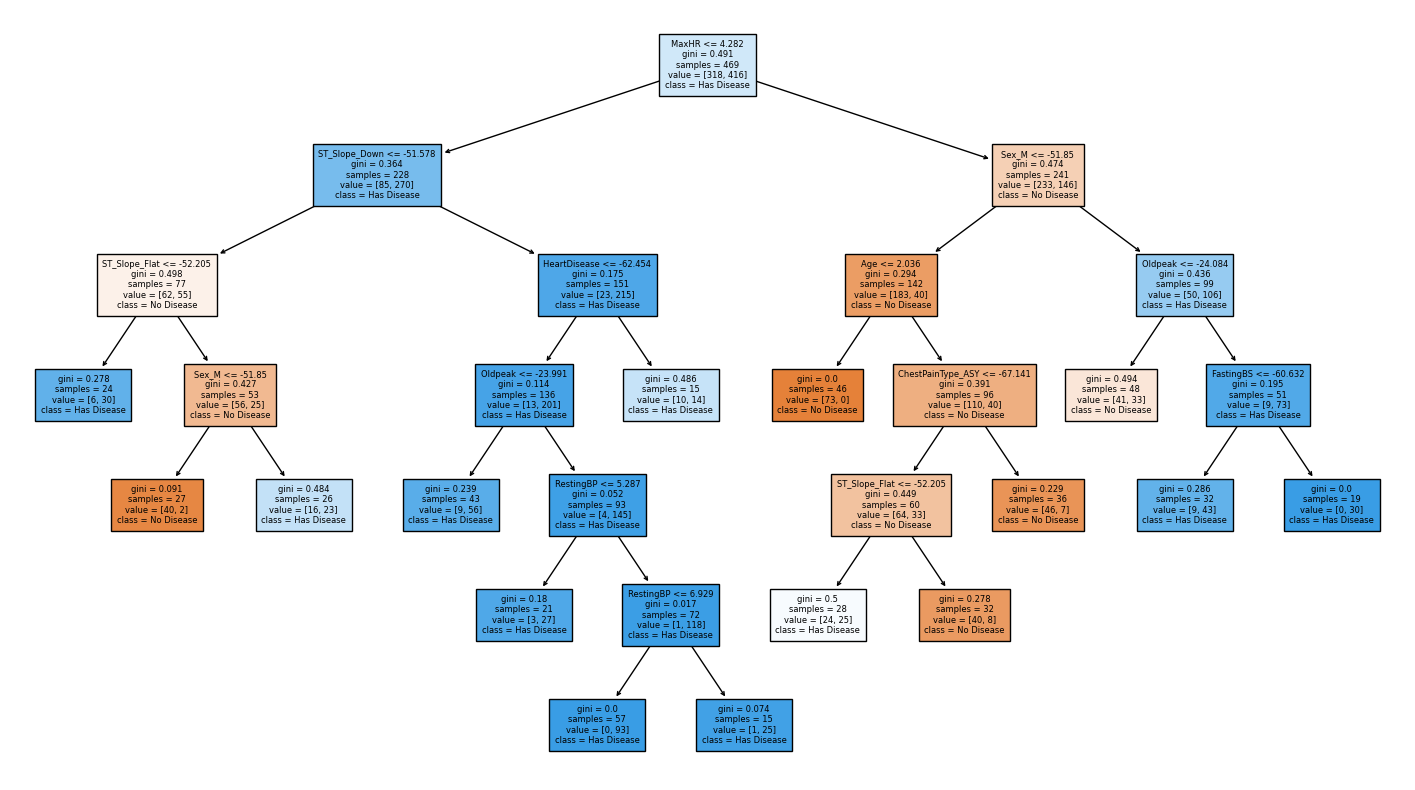

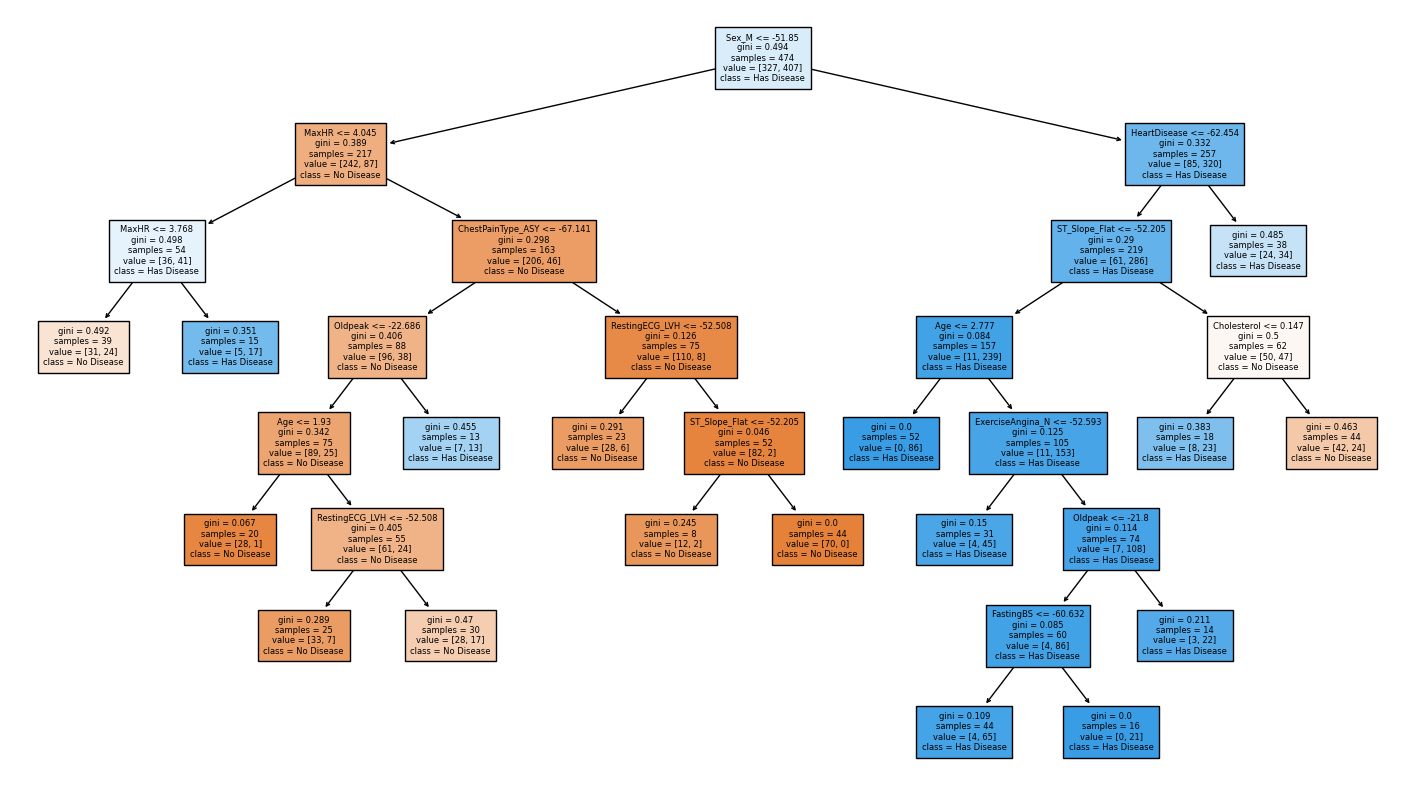

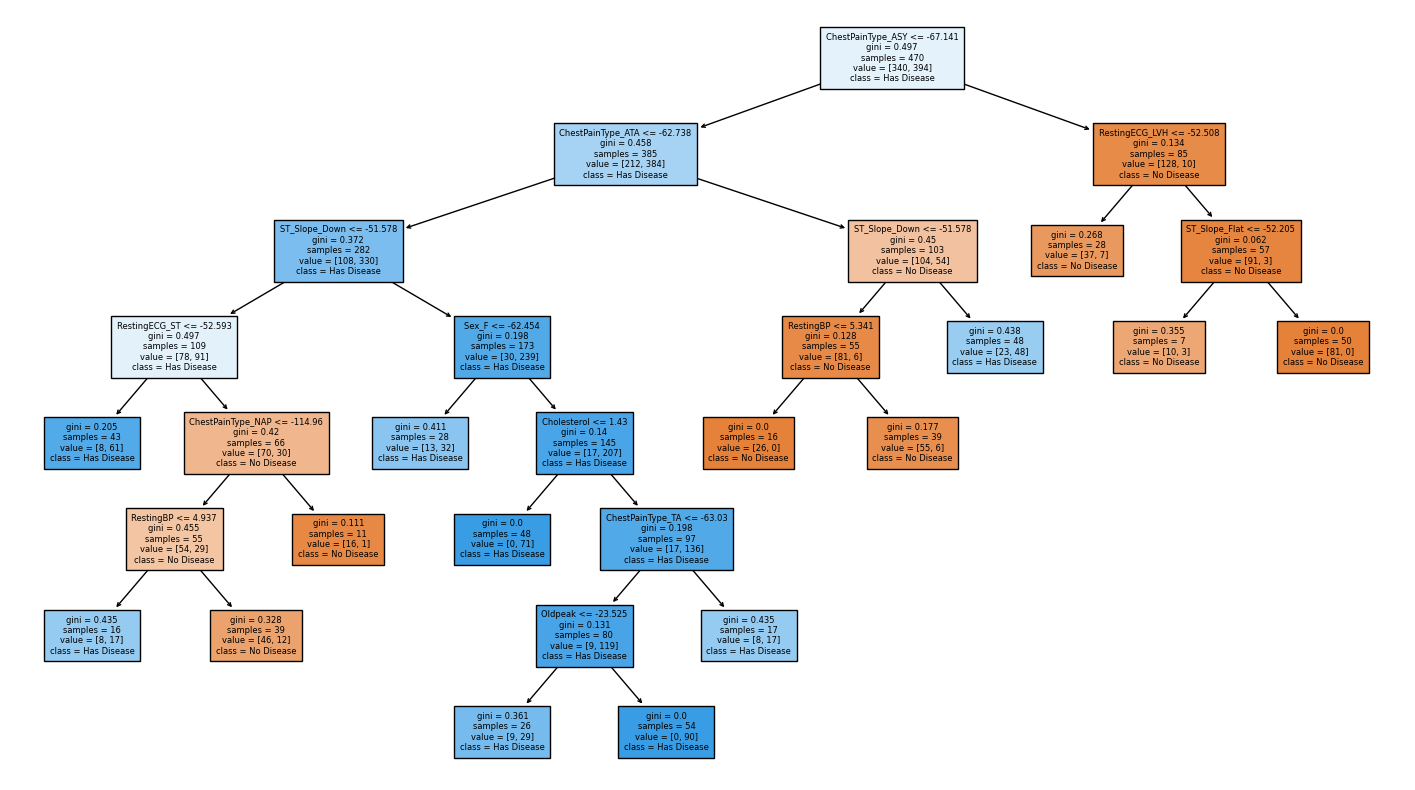

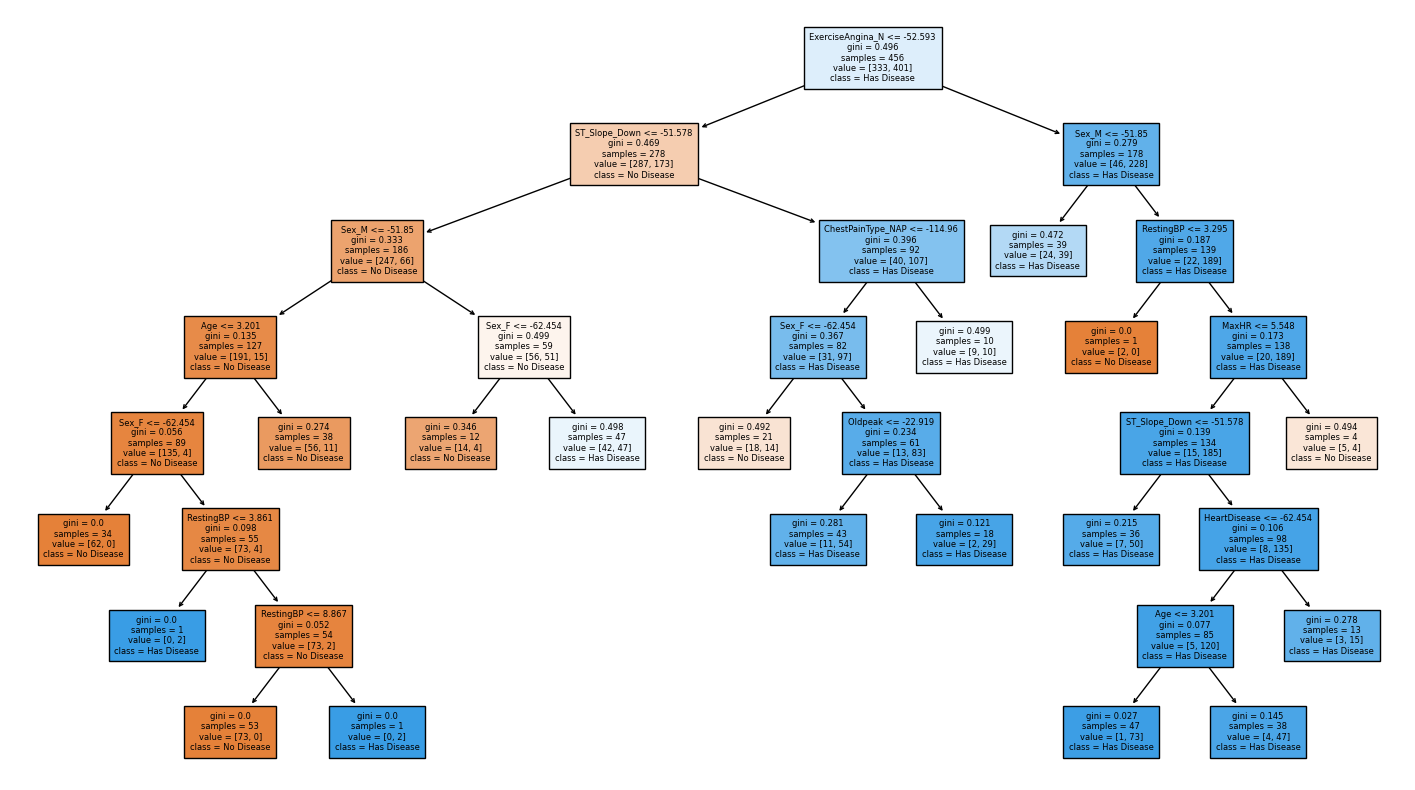

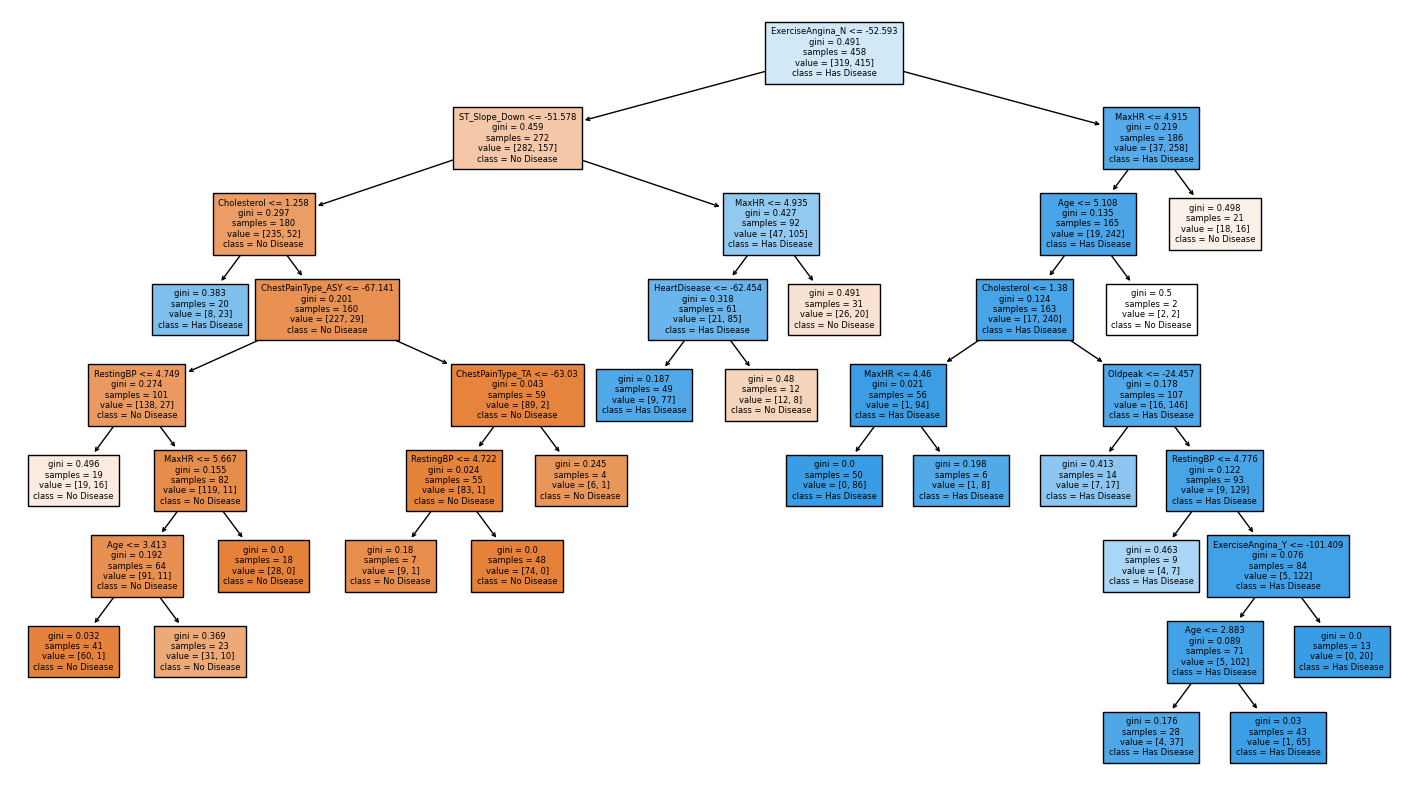

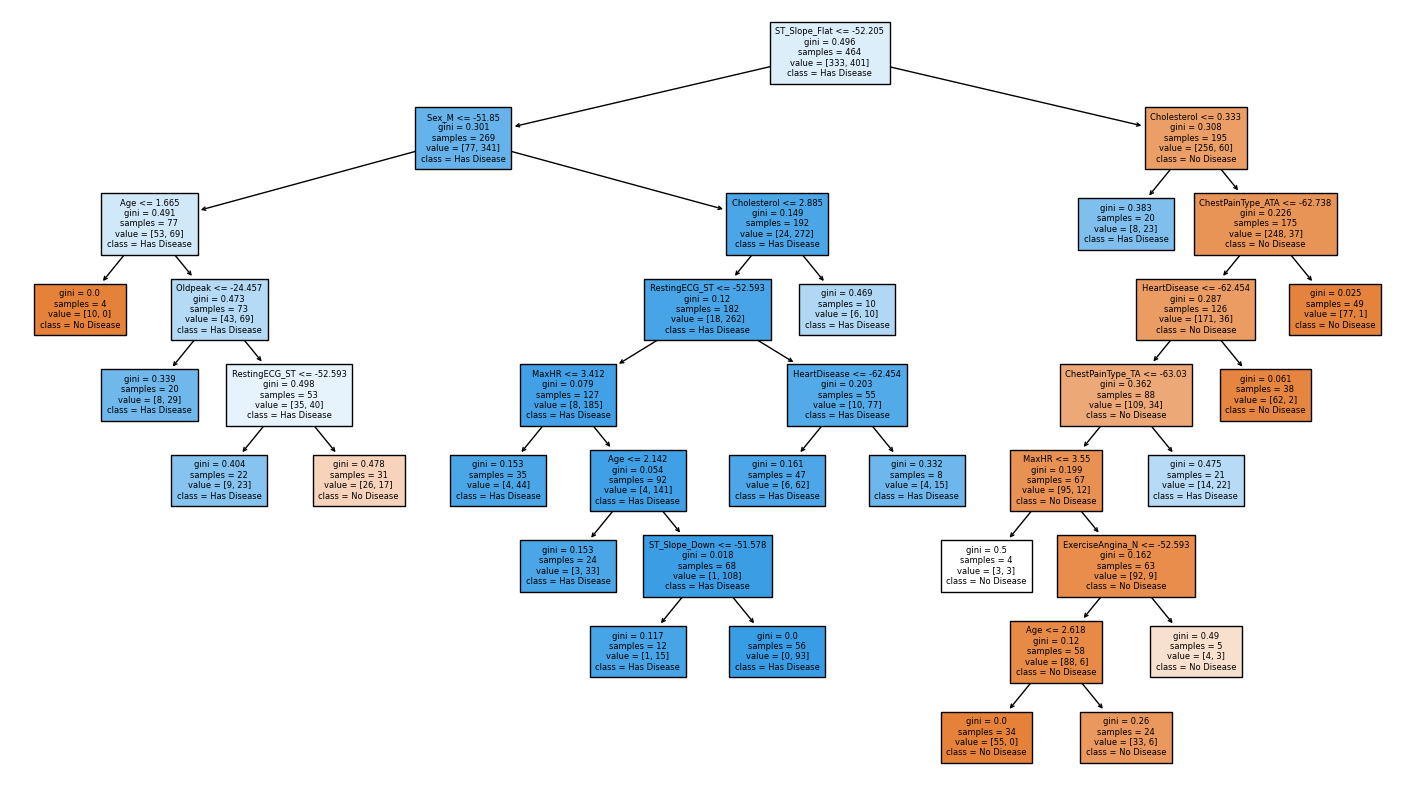

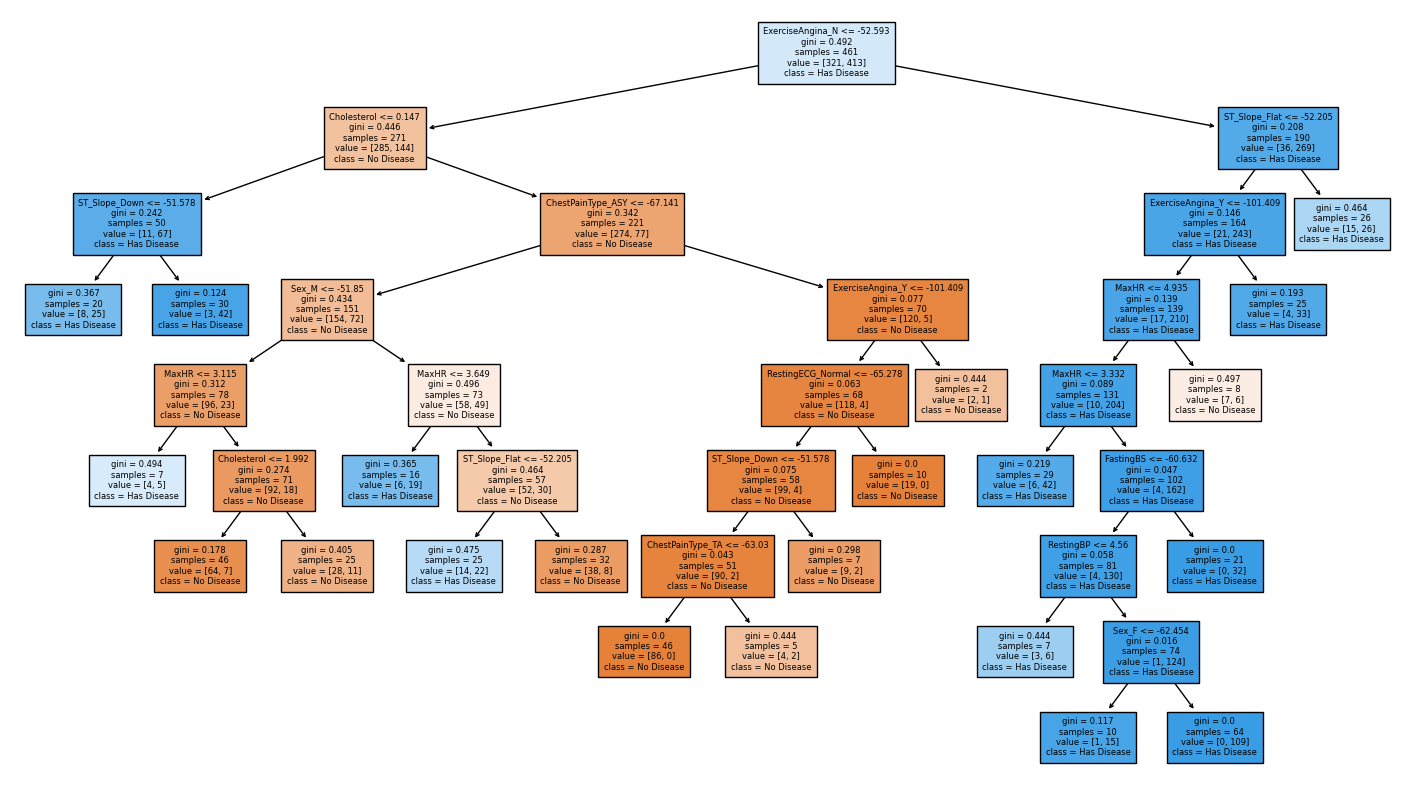

In [130]:
feature_names = list(df.columns)
# fig, ax = plt.subplots(1,1,figsize=(18,10))
random_forest_model = RandomForestClassifier(max_depth = 8, 
                                            min_samples_split = 50,
                                            n_estimators = 10,
                                            random_state = 21).fit(X_train, y_train)

train_pred = random_forest_model.predict(X_train)
val_pred = random_forest_model.predict(X_val)
print("Training accuracy: {:.2f}% | Validation accuracy: {:.2f}%".format(accuracy_score(train_pred, y_train)*100, accuracy_score(val_pred, y_val)*100)) 

for i in range(8):
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    tree.plot_tree(random_forest_model.estimators_[i], feature_names = feature_names, ax=ax, fontsize=6, class_names=['No Disease', 'Has Disease'], filled=True)
    filename = 'figures/random_forest/Fig_random_forest_tree_'+str(i+1)+'.png'
    plt.show()